#5. CNN을 이용한 분류 : CIFAR 10

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

##5.1 CIFAR 10 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#CIFAR 데이터셋 로드 및 전처리

#텐서로 변환 및 Normalize
#채널이 3개이기때문에 각 채널의 평균과 표준편차로 Normalize
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2) #배치 형태로 변환
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


In [ ]:
#Device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


##5.2 CNN 모델 구축

In [ ]:
class Net(nn.Module):
  def __init__ (self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) #합성곱 연산 (입력 채널 수 3, 출력 채널 수 6, 필터크기 5*5, stride = 1(디폴트))
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(16 * 5 * 5, 120) #16*5*5로 펼치기, 이후 120개짜리 히든 레이어로 만들기
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) #최종적으로 10개로 출력

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x))) #합성곱 연산, conv1 -> ReLU -> poll
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5) #일렬로 펼치기
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) #마지막에는 굳이 활성화함수 필요 없음
    return x


net = Net().to(device) #모델 선언

In [ ]:
####또 다른 표현####
class Net(nn.Module):
  def __init__ (self):
    super(Net, self).__init__()

    self.feature_extraction = nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(6, 16, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.classifier = nn.Sequential(
        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10))

  def forward(self, x):
    x = self.feature_extraction(x)
    x = x.view(-1, 16*5*5)
    x = self.classifier(x)
    return x

net = Net().to(device)

In [ ]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


##5.3 모델 학습

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001)

In [ ]:
loss_ = []
n = len(trainloader)

for epoch in range(10): #10번 반복
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data #GPU 연산에 적합한 형태로 변환
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() #매 반복마다 기울기 초기화

    outputs = net(inputs) #예측값 산출, 노드 10개짜리
    loss = criterion(outputs, labels) #손실함수 계산, label은 1~10의 숫자, output은 노드가 10개인 벡터
    loss.backward() #역전파
    optimizer.step() #가중치 업데이트

    running_loss += loss.item()

  loss_.append(running_loss/n) #배치마다 로스가 계산되기 때문.
  print('[%d] loss: %.3f' % (epoch + 1, running_loss/n))

print('finished training')

[1] loss: 1.747
[2] loss: 1.356
[3] loss: 1.216
[4] loss: 1.133
[5] loss: 1.065
[6] loss: 1.010
[7] loss: 0.962
[8] loss: 0.923
[9] loss: 0.889
[10] loss: 0.858
finished training


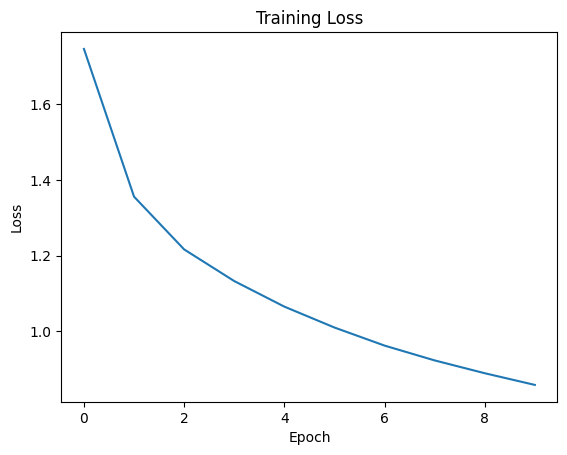

In [ ]:
#손실함수 시각화
plt.plot(loss_)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
#모델 저장하기
path = './cifar_net.pth' #모델 저장 경로
torch.save(net.state_dict(), path)

In [ ]:
#모델 불러오기
net = Net().to(device)
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
#모델 정확도 구현
#output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구함.

correct = 0
total = 0
with torch.no_grad():
  #net.eval() : Dropout 이나 BN등이 적용되었을 경우
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) #벡터의 노드값중에서 가장 큰 값이 클래스가 됨
    total += labels.size(0)
    correct += (predicted == labels).sum().item() #맞으면 1, 틀리면 0으로

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %
